# Time Series Analysis

## Dependencies and helper methods

In [7]:
#%cd ..

import numpy as np
import ipywidgets as widgets
import cv2
import imutils
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches as patches
import imutils
from scipy.signal import savgol_filter
import datetime
from scipy.interpolate import interp1d
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

array_segmented_images = np.load('./temp/array_segmented_images.npy')
array_data_cropped = np.load('./temp/array_data_cropped.npy')

with open('./temp/array_times.pickle', 'rb') as handle:
    array_times = pickle.load(handle)
    

# Prettier plots
import seaborn as sns
sns.set(font='Palatino',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'k',
 'axes.facecolor': 'None',
 'axes.grid' : False,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'xtick.bottom': True,
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})

# Vectorial plot
import matplotlib_inline.backend_inline as backend_inline 
backend_inline.set_matplotlib_formats('svg')

## Testing parallel loading of ZARR
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

def paral(func, lista, N, threads=True, processes=False):
    if processes:
        with ProcessPoolExecutor(max_workers=N) as executor:
            results = executor.map(func, lista)
        return list(results)
    elif threads:
        with ThreadPoolExecutor(max_workers=N) as executor:
            results = executor.map(func, lista)
        return list(results)

## Testing parallel loading of ZARR
def loadindex(index):
    try:
        return img[index][:]
    except Exception as e:
        print(e)
        
## Visualization method
def visualize_data(array_data, array_segments = None, array_times = None, cmap='crest'):
    # Widget slider to browse the data
    index = widgets.IntSlider(
        value=5, min=0, max=array_data.shape[0] - 1, step=1, description="Index"
    )

    # Other widget slider to browse the channels
    channel = widgets.IntSlider(
        value=5, min=0, max=array_data.shape[3] - 1, step=1, description="Channel"
    )

    # Checkbox to display RGB (override the channel)
    display_RGB = widgets.Checkbox(description="Display RGB", value=False)

    ui = widgets.HBox([index, channel, display_RGB])

    # Widget interaction function
    def anim(index_value, channel_value, display_RGB_value):
        fig = plt.figure(figsize=(10,8))
        if display_RGB_value:
            plt.imshow( array_data[index_value, :, :, (3,2,1)].swapaxes(0,1).swapaxes(1, 2))
        else:
            plt.imshow(array_data[index_value, :, :, channel_value], cmap = cmap)
        if array_segments is not None:
            if np.sum(array_segments[index_value])>0:
                plt.contour(array_segments[index_value], [0.5], colors='r')
        if array_times is not None:
            plt.title('Acquisition time: ' + str(array_times[index_value]))
        else:
            plt.title('Acquisition time: ' + str(df['beginposition'][index_value]))
        plt.axis('off')
        return

    # Link widget and function
    out = widgets.interactive_output(anim, {"index_value": index, 'channel_value': channel, 'display_RGB_value': display_RGB})

    # Display result
    return ui, out

## First evolution of the lake

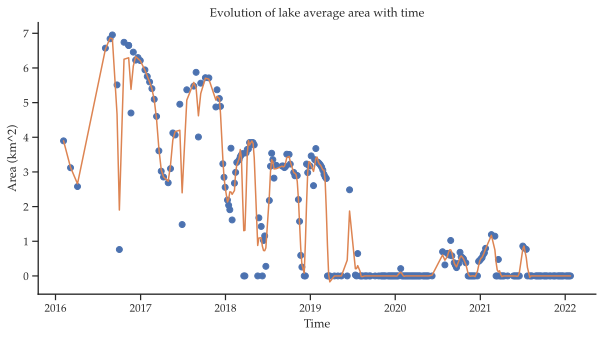

In [8]:
# Display area and detect images with abrupt change in segment with respect to the the previous and the next one 
array_area = np.array([np.sum(segment) for index, segment in enumerate(array_segmented_images)])

# Get time in proper units
array_times_int = np.array( [(x - datetime.datetime(1970, 1, 1)).total_seconds() for x in array_times])
array_times_int = (array_times_int - array_times_int[0]) / 10**6

# Interpolate the signal with a regular sampling for smoothing afterwards
f = interp1d(array_times_int, array_area, kind='linear')
xnew = np.linspace(0, array_times_int[-1], num=500, endpoint=True)
y_new = f(xnew)

# Smooth the signal with a Savgol filter
yhat = savgol_filter(y_new, 7, 3) # window size 7, polynomial order 3

# Reinterpolate 
f = interp1d(xnew, yhat, kind='linear')
y_hat_proper_sampling = f(array_times_int)


# Plot the smoothed signal
plt.figure(figsize=(10,5),facecolor="white")
plt.plot(array_times, array_area * 100/1000000, 'o', array_times, y_hat_proper_sampling* 100/1000000, '-')
plt.xlabel('Time')
plt.ylabel('Area (km^2)')
plt.title('Evolution of lake average area with time')
plt.show()

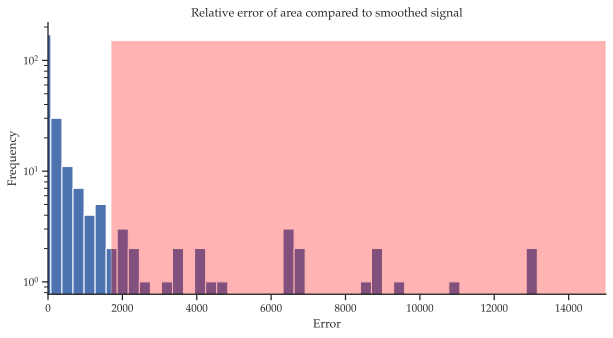

In [9]:
# Plot histogram of relative error compared to smoothed signal 
fig, ax = plt.subplots(1, figsize = (10,5))
l_relative_error = (array_area-y_hat_proper_sampling)**2/np.array(y_hat_proper_sampling+1)
fig.patch.set_facecolor('white')
plt.hist(l_relative_error , bins=50)
plt.xlim(0, 15000)
plt.xlabel("Error")
plt.ylabel("Frequency")
tresh = 1700
# Create one rectangle patch and add it to the plot
rect = patches.Rectangle((tresh, 0), 15000-tresh, 150, alpha = 0.3, facecolor="red")
ax.add_patch(rect)

ax.set_yscale('log')
#plt.ylim(0,150)
plt.title('Relative error of area compared to smoothed signal')
plt.show()

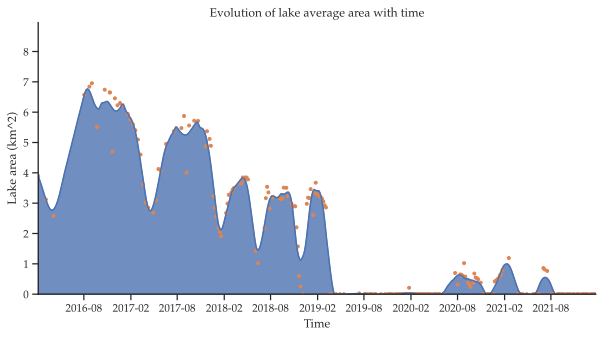

In [11]:
# Discard the points that are too far from the smooth signals (outliers)
l_idx_to_keep = [index for index, error in enumerate(l_relative_error) if error < tresh]
array_area_filtered = array_area[l_idx_to_keep]*100/1000000 # To have km^2 for now
array_data_filtered = array_data_cropped[l_idx_to_keep]
array_times_filtered = np.array(array_times)[l_idx_to_keep]
array_times_int_filtered = np.array(array_times_int)[l_idx_to_keep]
array_segmented_images_filtered = array_segmented_images[l_idx_to_keep]

# Make a last smooth version 
f = interp1d(array_times_int_filtered, array_area_filtered, kind='slinear')
xnew = np.linspace(0, array_times_int_filtered[-1], num=500, endpoint=True)
yhat = [x if x>=0 else 0 for x  in savgol_filter(f(xnew), 21, 3)]
x_times = [datetime.datetime.fromtimestamp(x) for x in xnew * 10**6 + array_times_filtered[0].timestamp() ]


# Plot the final curve
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(array_times_filtered , array_area_filtered, '.', c = 'C1')
plt.plot( x_times, yhat, '-', c = 'C0')
ax.fill_between(x_times, yhat, 0, color='C0', alpha=.8)
plt.xlabel('Time')
plt.ylabel('Lake area (km^2)')
plt.xlim(array_times_filtered[0], array_times_filtered[-1])
plt.ylim([0, np.max(array_area_filtered+2)])
# Define the date format
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.title('Evolution of lake average area with time')
plt.show()

## Study of the algae content within segmented regions

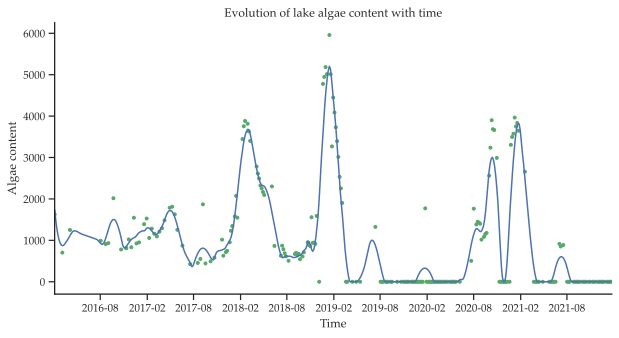

In [12]:
# Compute algae content for each acquisition
l_mean_algae = [np.mean(array_data_filtered[index,:,:,6][segment==1]) if np.sum(segment)>0 else 0 for index, segment in enumerate(array_segmented_images_filtered)]

# Smooth the signal with a Savgol filter
f = interp1d(array_times_int_filtered, l_mean_algae, kind='slinear')
xnew = np.linspace(0, array_times_int_filtered[-1], num=500, endpoint=True)
yhat_algae = [x if x>=0 else 0 for x  in savgol_filter(f(xnew), 21, 3)]
x_times = [datetime.datetime.fromtimestamp(x) for x in xnew * 10**6 + array_times_filtered[0].timestamp() ]

# Plot the final curve
fig, ax = plt.subplots(figsize=(10,5))
fig.patch.set_facecolor('white')
plt.plot(array_times_filtered , l_mean_algae, '.', c = 'C2')
plt.plot( x_times, yhat_algae, '-', c = 'C0')

plt.xlabel('Time')
plt.ylabel('Algae content')
plt.xlim(array_times_filtered[0], array_times_filtered[-1])
#plt.ylim([0, np.max(array_area_filtered+2000)])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.title('Evolution of lake algae content with time')
plt.show()

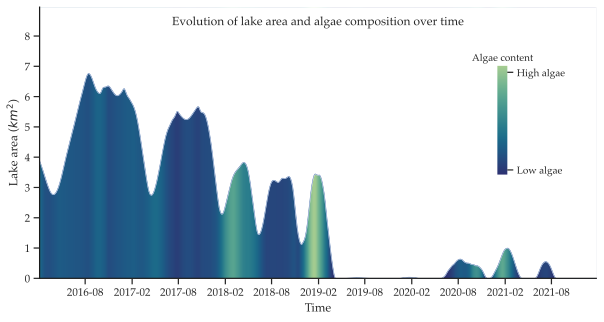

In [13]:
# Scale for main axes
ylims = [0, np.max(array_area_filtered+2)]
xlims = mdates.date2num([array_times_filtered[0], array_times_filtered[-1]])

# Scale for the colorbar
min_algae = np.min(yhat_algae)
max_algae = np.max(yhat_algae)
scale_algae = max_algae - min_algae

# Draw the image over the whole plot area
fig, ax = plt.subplots(figsize=(10,5))
fig.patch.set_facecolor('white')
im = plt.imshow(np.array([yhat_algae]), cmap='crest_r', origin='lower', extent=[xlims[0], xlims[1], ylims[0],  ylims[1]],aspect='auto')

# Erase above the data by filling with white
plt.fill_between(x_times, yhat, ylims[1], color='w')

# Make the line plot over the top
plt.plot(x_times, yhat, 'C0', linewidth=0.5)


# Set limits
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# Labels
plt.xlabel('Time')
plt.ylabel('Lake area ' + r'($km^2$)')
ax.set_title('Evolution of lake area and algae composition over time', y=1.0, pad=-18)

# More customization
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Define the date format
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

#add color bar
cbaxes = inset_axes(ax, width="2%", height="50%", bbox_to_anchor = [0,0,0.85,0.8], bbox_transform=ax.transAxes, loc=1) 
t = fig.colorbar(im, cax=cbaxes, orientation='vertical', ticks=[min_algae + scale_algae * 0.05, max_algae - scale_algae * 0.05])
cbaxes.set_title('Algae content', size=10)
cbaxes.set_yticklabels(['Low algae', 'High algae'], size = 10) 
t.outline.set_visible(False)

plt.show()